In [2]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk 
from nltk.corpus import stopwords
import string
import re
import ast
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import swifter
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split

#Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelEncoder
# %matplotlib inline
# pd.set_option('display.max_colwidth', 100)

In [4]:

# Load dataset
def load_data():
    data = pd.read_csv('data testing.csv')#ubah nama file sesai dengan nama file kalian
    return data

df = load_data()

#definisi dataframe
df  = pd.DataFrame(df[['username','content']])#ubah dataframe sesuai column kalian
df = df.dropna().reset_index(drop=True)
# df.to_csv('dataset fix.csv',index=False)


In [5]:
#====================================Cleansing=====================================#
#remove usero
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt    
df['remove_user'] = np.vectorize(remove_pattern)(df['content'], "@[\w]*")


In [6]:

import re
def casefolding(content):
    content = content.lower()
    content = content.strip(" ")
    content = re.sub(r'[?|.|!_:")(-+,#]','', content)
    return content
df['casefolding'] = df['content'].apply(casefolding)
df['casefolding']


0      capek banget tapi disisi lain bersyukur allah ...
1      💙 he called me good girl omg my hearbeat like ...
2      💙 guys mau tanya ada yang tau hrgaa pasaran ci...
3      💭 disini ada gk yang rahangnya bunyi kuat pas ...
4                               💙 bagi meme banteng dong
                             ...                        
295    💭 doain aku ya guys tahun ini lolos snbt biar ...
296    💙 buat yg cewe kalian kalo pake kemeja putih b...
297    💭 kalian ada yg punya temen namanya ali kalian...
298                    💙 mau liat lockscreen kalian dong
299    💭 besok akun-akun base beneran bakal shut down...
Name: casefolding, Length: 300, dtype: object

In [7]:
#  #=================================Stopword========================================#
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary

def stop(text):
    text = text.lower()
    factory = StopWordRemoverFactory()
    more_stopword = ['dengan', 'ia','bahwa','oleh', 'dan', 'bagi', 'lu', 'gw', 'yang', 'tapi', 
                    'q', 'https', 'promo', 'gampang', 'full', 'mas', 'part', 'yuk', 'yg', 'dll', 'dst', 'mas',
                    'ade', 'follow', 'akunnya', 'yang', 'akun','hadir', 'saksi',
                    'channel', 'lupa', 'awet', 'sumber','selamat', 'pagi', 'siang', 'sore', 'malam',
                    'dgn', 'msh', 'hayo', 'suka', 'gaji']
    data = factory.get_stop_words()+more_stopword
    dictionary = ArrayDictionary(data)
    stopword= factory.create_stop_word_remover()
    stopp = StopWordRemover(dictionary)
    out = stopp.remove(text)
    return out

df['stopword'] = df['casefolding'].apply(stop)

In [8]:
#=================================Tokenizing========================================#
#tokenize
from nltk.tokenize import TweetTokenizer

def token(tweet):
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)
    return tweet_tokens

df['token'] = df['stopword'].apply(token)

In [9]:
def symclean(text):
    tokens = text
    # remove all tokens that are not alphabetic
    words = [word for word in tokens if word.isalpha()]
    return words
df['remove_sym'] = df['token'].apply(symclean)

In [10]:
# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# stemmed
def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}

for document in df['remove_sym']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '
            
for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)
    
# apply stemmed term to dataframe
def get_stemmed_term(document):
    return [term_dict[term] for term in document]
df['stemming'] = df['remove_sym'].swifter.apply(get_stemmed_term)

Pandas Apply:   0%|          | 0/300 [00:00<?, ?it/s]

In [11]:
def join(text):
    string =' '.join(map(str,text))
    return string

df['finale'] = df['stemming'].apply(join)

def stop(text):
    text = text.lower()
    factory = StopWordRemoverFactory()
    more_stopword = ['dengan', 'ia','bahwa','oleh', 'dan', 'bagi', 'lu', 'gw', 'yang', 'tapi', 
                    'q', 'https', 'promo', 'gampang', 'full', 'mas', 'part', 'yuk', 'yg', 'dll', 'dst', 'mas',
                    'ade', 'follow', 'akunnya', 'yang', 'akun','hadir', 'saksi',
                    'channel', 'lupa', 'awet', 'sumber','selamat', 'pagi', 'siang', 'sore', 'malam',
                    'dgn', 'msh', 'hayo', 'suka', 'gaji']
    data = factory.get_stop_words()+more_stopword
    dictionary = ArrayDictionary(data)
    stopword= factory.create_stop_word_remover()
    stopp = StopWordRemover(dictionary)
    out = stopp.remove(text)
    return out

df['final'] = df['finale'].apply(stop)
df['final']

0      capek banget sisi syukur allah cpt ngasih tau ...
1      he called me good girl omg my hearbeat like ao...
2      guys mau tanya tau hrgaa pasar cincin couple e...
3      sini gk rahang bunyi kuat pas buka mulut rasa ...
4                                      meme banteng dong
                             ...                        
295    doain aku guys tahun lolos snbt biar ngekos ng...
296    buat cewe kalian kalo pake kemeja putih biar g...
297    kalian punya temen nama ali kalian biasa mangg...
298                      mau liat lockscreen kalian dong
299                   besok base beneran bakal shut down
Name: final, Length: 300, dtype: object

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import normalize

max_features = 1000

def generate_tfidf_mat(min_gram, max_gram):
    cvect = CountVectorizer(max_features=max_features, ngram_range=(min_gram, max_gram))
    counts = cvect.fit_transform(df["final"])

    normalized_counts = normalize(counts, norm='l1', axis=1)

    tfidf = TfidfVectorizer(max_features=max_features, ngram_range=(min_gram, max_gram), smooth_idf=False)
    tfs = tfidf.fit_transform(df["final"])

    tfidf_mat = normalized_counts.multiply(tfidf.idf_).toarray()
    
    TF = normalized_counts.toarray()
    IDF = tfidf.idf_
    TF_IDF = tfidf_mat
    return TF, IDF, TF_IDF, tfidf.get_feature_names()

# ngram_range (1, 1) to use unigram only
tf_mat_unigram, idf_mat_unigram, tfidf_mat_unigram, terms_unigram = generate_tfidf_mat(1,1)

# ngram_range (2, 2) to use bigram only
tf_mat_bigram, idf_mat_bigram, tfidf_mat_bigram, terms_bigram = generate_tfidf_mat(2,2)

# ngram_range (3, 3) to use trigram only
tf_mat_trigram, idf_mat_trigram, tfidf_mat_trigram, terms_trigram = generate_tfidf_mat(3,3)
        
def get_TF_unigram(row):
    idx = row.name
    return [tf for tf in tf_mat_unigram[idx] if tf != 0.0]

df["TF"] = df.apply(get_TF_unigram, axis=1)

def get_IDF_unigram(row):
    idx = row.name
    return [item[1] for item in zip(tf_mat_unigram[idx], idf_mat_unigram) if item[0] != 0.0]

df["IDF"] = df.apply(get_IDF_unigram, axis=1)

def get_TFIDF_unigram(row):
    idx = row.name
    return [tfidf for tfidf in tfidf_mat_unigram[idx] if tfidf != 0.0]

df["TFIDF"] = df.apply(get_TFIDF_unigram, axis=1)

df[["final", "TF", "IDF", "TFIDF"]]

# save TFIDF Unigram to Excel

# df[["final", "TF_UNIGRAM", "IDF_UNIGRAM", "TFIDF_UNIGRAM"]].to_csv("TFIDF_Unigram.csv")


,final,TF,IDF,TFIDF
0,capek banget sisi syukur allah cpt ngasih tau ...,"[0.14285714285714285, 0.07142857142857142, 0.0...","[2.6784307839210517, 5.0943445622221, 3.870569...","[0.3826329691315788, 0.3638817544444357, 0.276..."
1,he called me good girl omg my hearbeat like ao...,"[0.2, 0.2, 0.2, 0.2, 0.2]","[5.605170185988092, 5.605170185988092, 5.31748...","[1.1210340371976184, 1.1210340371976184, 1.063..."
2,guys mau tanya tau hrgaa pasar cincin couple e...,"[0.07692307692307693, 0.07692307692307693, 0.0...","[4.912023005428146, 6.703782474656201, 6.70378...","[0.3778479234944728, 0.515675574973554, 0.5156..."
3,sini gk rahang bunyi kuat pas buka mulut rasa ...,"[0.041666666666666664, 0.041666666666666664, 0...","[3.336486644669727, 6.0106352940962555, 2.9425...","[0.13902027686123863, 0.25044313725401063, 0.1..."
4,meme banteng dong,"[0.5, 0.5]","[3.5682882587270512, 4.401197381662156]","[1.7841441293635256, 2.200598690831078]"
...,...,...,...,...
295,doain aku guys tahun lolos snbt biar ngekos ng...,"[0.18181818181818182, 0.09090909090909091, 0.0...","[2.6784307839210517, 4.218875824868201, 5.6051...","[0.4869874152583731, 0.3835341658971092, 0.509..."
296,buat cewe kalian kalo pake kemeja putih biar g...,"[0.09090909090909091, 0.09090909090909091, 0.0...","[2.9425823589626385, 4.218875824868201, 3.6592...","[0.2675074871784217, 0.3835341658971092, 0.332..."
297,kalian punya temen nama ali kalian biasa mangg...,"[0.125, 0.125, 0.25, 0.125, 0.125, 0.125, 0.125]","[4.912023005428146, 3.870569130599985, 2.83258...","[0.6140028756785183, 0.48382114132499815, 0.70..."
298,mau liat lockscreen kalian dong,"[0.25, 0.25, 0.25, 0.25]","[3.5682882587270512, 2.83258146374831, 4.40119...","[0.8920720646817628, 0.7081453659370776, 1.100..."


In [13]:
#Train Data
def data_train():
    data = pd.read_csv('final.csv')#ubah nama file sesai dengan nama file kalian
    return data
df_train = data_train()
#definisi dataframe
df_train = df_train.rename(columns={'finale': 'caption'})
df_train  = pd.DataFrame(df_train[['caption','sentiment']])
df_train = df_train.dropna().reset_index(drop=True)#ubah dataframe sesuai column kalian

# count_vect = CountVectorizer()
# X_train_counts = count_vect.fit_transform(df_train["caption"])
tfidf = TfidfVectorizer(max_df=1.0, min_df=1)
X = tfidf.fit_transform(df_train["caption"])

enc = LabelEncoder()
df_train['encoding'] = enc.fit_transform(df_train['sentiment'])
y = df_train['encoding']


#Test Data
# X_test_counts = count_vect.fit_transform(df["final"])
X_test_uji = tfidf.transform(df["final"])
df['sentiment'] = ''
y_test_uji = df[['sentiment']]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=85)
print ((X_train.shape),(y_train.shape),(X_test_uji.shape), (y_test_uji.shape))

(560, 3010) (560,) (300, 3010) (300, 1)


['N' 'N' 'O' 'O' 'O' 'E' 'O' 'A' 'E' 'C' 'N' 'A' 'A' 'N' 'O' 'O' 'O' 'C'
 'N' 'E' 'C' 'C' 'O' 'O' 'C' 'O' 'O' 'C' 'C' 'O' 'O' 'C' 'C' 'C' 'A' 'A'
 'C' 'C' 'O' 'O' 'N' 'O' 'C' 'N' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'N' 'C'
 'N' 'O' 'E' 'O' 'A' 'O' 'N' 'O' 'N' 'A' 'E' 'A' 'A' 'O' 'O' 'N' 'N' 'N'
 'E' 'A' 'E' 'C' 'N' 'A' 'N' 'A' 'N' 'O' 'C' 'N' 'E' 'O' 'N' 'O' 'C' 'A'
 'C' 'N' 'N' 'A' 'A' 'N' 'O' 'N' 'N' 'O' 'N' 'E' 'E' 'E' 'O' 'O' 'C' 'A'
 'C' 'E' 'C' 'O' 'E' 'C' 'C' 'O' 'N' 'O' 'E' 'C' 'O' 'E' 'E' 'C' 'N' 'N'
 'N' 'C' 'C' 'E' 'N' 'C' 'E' 'C' 'E' 'A' 'C' 'O' 'O' 'N' 'E' 'C' 'C' 'N'
 'N' 'E' 'A' 'E' 'E' 'O' 'E' 'C' 'O' 'E' 'N' 'N' 'E' 'E' 'N' 'C' 'E' 'C'
 'C' 'O' 'A' 'N' 'A' 'C' 'C' 'A' 'E' 'E' 'N' 'C' 'E' 'E' 'N' 'E' 'O' 'N'
 'C' 'N' 'A' 'N' 'A' 'E' 'C' 'O' 'E' 'C' 'N' 'C' 'E' 'N' 'N' 'O' 'N' 'O'
 'N' 'O' 'E' 'O' 'O' 'O' 'N' 'C' 'E' 'C' 'C' 'E' 'N' 'C' 'O' 'N' 'O' 'C'
 'N' 'C' 'N' 'C' 'O' 'N' 'E' 'N' 'A' 'E' 'O' 'E' 'A' 'C' 'N' 'A' 'N' 'E'
 'C' 'C' 'C' 'C' 'O' 'A' 'E' 'N' 'N' 'E' 'O' 'O' 'A

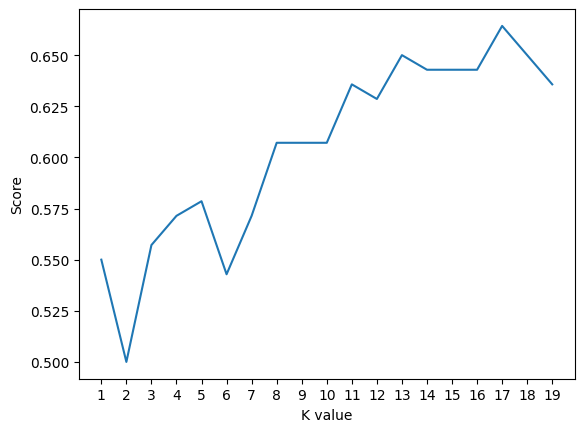

Maximum KNN Score is 66.43%


In [15]:
accuracies = {}

#KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5)  # n_neighbors means k
knn.fit(X_train, y_train)

Y_pred = knn.predict(X_test_uji)
pred = enc.inverse_transform(Y_pred)
df['sentiment'] = pred
# df
print (pred)
predictions = [round(value) for value in Y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test_uji, predictions)
accuracies['KNN'] = accuracy* 100.0
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# #try to find best k value
scoreList = []
for i in range(1,20):
    knn2 = KNeighborsClassifier(n_neighbors = i)  # n_neighbors means k
    knn2.fit(X_train, y_train)
    scoreList.append(knn2.score(X_test,y_test))
    
plt.plot(range(1,20), scoreList)
plt.xticks(np.arange(1,20,1))
plt.xlabel("K value")
plt.ylabel("Score")
plt.show()

acc = max(scoreList)*100

print("Maximum KNN Score is {:.2f}%".format(acc))

Model Accuracy on Test Data: 0.5785714285714286
              precision    recall  f1-score   support

           0       0.68      0.93      0.79        28
           1       0.50      0.46      0.48        28
           2       0.63      0.68      0.66        28
           3       0.50      0.43      0.46        28
           4       0.50      0.39      0.44        28

    accuracy                           0.58       140
   macro avg       0.56      0.58      0.57       140
weighted avg       0.56      0.58      0.57       140



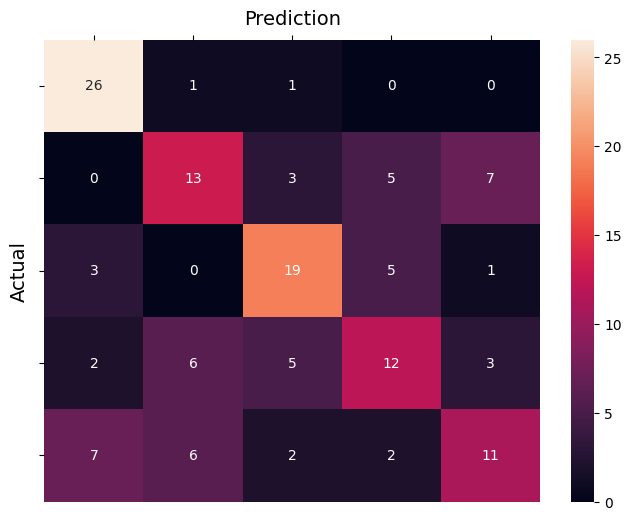

In [16]:
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Model Accuracy on Test Data:', accuracy)
confusion_matrix(y_test, y_pred)
print (classification_report(y_test, y_pred))

fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(confusion_matrix(y_true = y_test, y_pred = y_pred), fmt = 'g', annot = True)
ax.xaxis.set_label_position('top')
ax.xaxis.set_ticks_position('top')
ax.set_xlabel('Prediction', fontsize = 14)
ax.set_xticklabels([])
ax.set_ylabel('Actual', fontsize = 14)
ax.set_yticklabels([])
plt.show()

In [17]:
# Visualisasi data funciton
def show_pie(label, data, legend_title) :
    fig, ax = plt.subplots(figsize=(8, 10), subplot_kw=dict(aspect='equal'))

    labels = [x.split()[-1] for x in label]

    def func(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals))
        return "{:.1f}% ({:d})".format(pct, absolute)

    wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data), 
                                      textprops=dict(color="w"))

    ax.legend(wedges, labels,
              title= legend_title,
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))

    plt.setp(autotexts, size=10, weight="bold")
    plt.show()

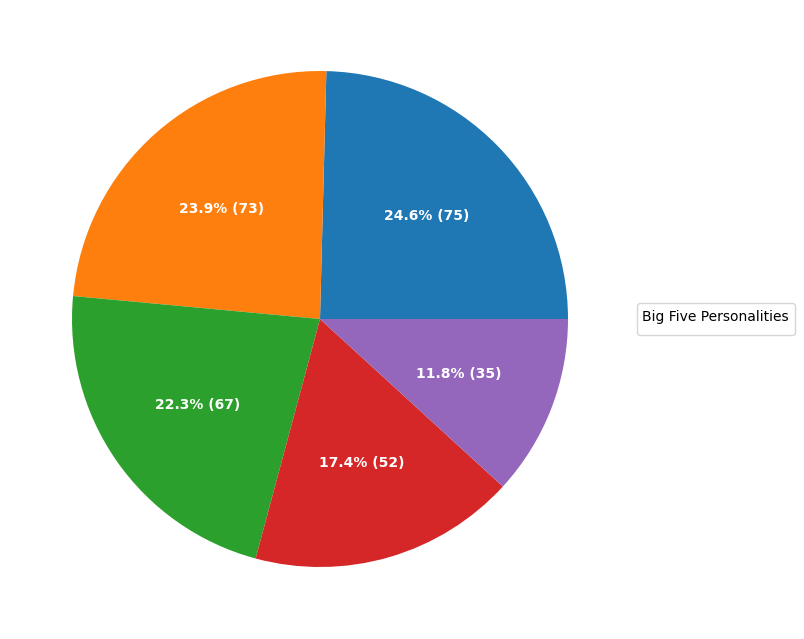

In [18]:
#pie data tweet
label = []
count_data = np.array(df["sentiment"].value_counts())+1

show_pie(label, count_data, "Big Five Personalities")